## Описание работы

Есть разрозненные файлы с данными о действиях людей на каждом этапе воронки по нескольким рекламным кампаниям. 

Цель - изучить и подготовить датасеты, ответить на вопросы и выполнить проверку гипотез.

Задачи:
1) Ответить на вопросы:
- Выявить скомпрометированные данные, построить распределение активности по этапам воронки. Сделать вывод, почему представленные этапы были легко атакованы ботами.
- Какой канал коммуникации с клиентом является менее перспективным?
- Построить распределение операционной системы пользователя для каждого канала коммуникации и сделать выводы.
- Определить лучший и худший каналы по данным на этапах consideration, intent, purchase.
- Какой канал следует отключить и перераспределить показы, чтобы увеличить продажи?

2) Проверить гипотезу:
- Насколько статистически значимы отличия между долями пользователей на каждом этапе воронки между платным и органическим трафиком?



## 1. Импорт сторонних библиотек

In [1]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as st
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer import FactorAnalyzer
from matplotlib import ticker

## 2. Загрузка данных

1. Загрузка данных из файлов. 

In [2]:
advertising_information = pd.read_json('Данные для кейса/advertising_information.json')
banner = pd.read_excel('Данные для кейса/banner.xlsx')
rich = pd.read_excel('Данные для кейса/rich.xlsx')
native = pd.read_csv('Данные для кейса/native.csv', usecols = ['user_id', 'funnel_stage', 'timestamp', 'profit', 'os'])
organic_traffic = pd.read_csv('Данные для кейса/organic_traffic.csv', 
                              usecols = [1, 2, 3, 4, 5], 
                              names = ['user_id', 'funnel_stage', 'timestamp', 'profit', 'os']
                             )
other = pd.read_csv('Данные для кейса/other.csv', usecols = ['user_id', 'funnel_stage', 'timestamp', 'profit', 'os'])
partner_network = pd.read_csv('Данные для кейса/partner_network.csv', 
                              usecols = [1, 2, 3, 4, 5], 
                              names = ['user_id', 'funnel_stage', 'timestamp', 'profit', 'os']
                             )
search = pd.read_csv('Данные для кейса/search.csv', usecols = ['user_id', 'funnel_stage', 'timestamp', 'profit', 'os'])
video = pd.read_csv('Данные для кейса/video.csv', usecols = ['user_id', 'funnel_stage', 'timestamp', 'profit', 'os'])

2. Вывод размерности и первых 5 строчек данных.

In [3]:
print(f'Размерность датасета advertising_information: {advertising_information.shape}')
advertising_information.head()

Размерность датасета advertising_information: (8, 2)


,ad_channel,price
0,search,1.50
1,banner,0.50
2,video,0.75
3,native,2.00
4,partner_network,1.00


In [4]:
print(f'Размерность датасета banner: {banner.shape}')
banner.head()

Размерность датасета banner: (576169, 5)


,user_id,funnel_stage,timestamp,profit,os
0,219687,interest,150000,NaN,Android
1,335514,interest,150000,NaN,Android
2,108759,interest,150000,NaN,Android
3,795063,interest,150000,NaN,Android
4,928373,interest,150000,NaN,iOS


In [5]:
print(f'Размерность датасета rich: {rich.shape}')
rich.head()

Размерность датасета rich: (64088, 5)


,user_id,funnel_stage,timestamp,profit,os
0,263061,INTEREST,150020,NaN,iOS
1,803654,CONSIDERATION,150041,NaN,iOS
2,320634,INTEREST,150042,NaN,iOS
3,654929,CONSIDERATION,150042,NaN,iOS
4,401613,INTEREST,150045,NaN,iOS


In [6]:
print(f'Размерность датасета native: {native.shape}')
native.head()

Размерность датасета native: (117575, 5)


,user_id,funnel_stage,timestamp,profit,os
0,991236,interest,150000,NaN,Android
1,622708,interest,150002,NaN,iOS
2,334823,interest,150003,NaN,Android
3,699175,consideration,150004,NaN,iOS
4,855631,interest,150010,NaN,iOS


In [7]:
print(f'Размерность датасета organic_traffic: {organic_traffic.shape}')
organic_traffic.head()

Размерность датасета organic_traffic: (531584, 5)


,user_id,funnel_stage,timestamp,profit,os
0,897013,interest,150000,NaN,Android
1,242700,interest,150000,NaN,Android
2,143856,interest,150000,NaN,Android
3,26717,consideration,150000,NaN,Android
4,286799,interest,150001,NaN,Android


In [8]:
print(f'Размерность датасета other: {other.shape}')
other.head()

Размерность датасета other: (22588, 5)


,user_id,funnel_stage,timestamp,profit,os
0,619081,consideration,150013,NaN,iOS
1,900637,consideration,150013,NaN,iOS
2,551565,interest,150017,NaN,iOS
3,1037574,interest,150023,NaN,Android
4,1048472,interest,150047,NaN,Android


In [9]:
print(f'Размерность датасета partner_network: {partner_network.shape}')
partner_network.head()

Размерность датасета partner_network: (387430, 5)


,user_id,funnel_stage,timestamp,profit,os
0,829539,interest,150003,NaN,iOS
1,817640,interest,150003,NaN,Android
2,890248,purchase,150003,2136.0,Android
3,1050415,interest,150004,NaN,Android
4,586829,interest,150004,NaN,iOS


In [10]:
print(f'Размерность датасета search: {search.shape}')
search.head()

Размерность датасета search: (1491205, 5)


,user_id,funnel_stage,timestamp,profit,os
0,387356,INTEREST,150000,NaN,iOS
1,619571,CONSIDERATION,150000,NaN,iOS
2,230119,INTEREST,150000,NaN,iOS
3,399556,INTEREST,150000,NaN,iOS
4,556959,INTEREST,150001,NaN,Android


In [11]:
print(f'Размерность датасета video: {video.shape}')
video.head()

Размерность датасета video: (655068, 5)


,user_id,funnel_stage,timestamp,profit,os
0,111649,consideration,150000,NaN,Android
1,793204,consideration,150000,NaN,Android
2,107750,interest,150001,NaN,Android
3,438176,interest,150001,NaN,Android
4,515596,consideration,150003,NaN,Android


## 3. Data Preparation

Перед объединением датасетов проведем подготовку данных.

1. В колонку `ad_channel` добавим название канала коммуникации, взяв его из соответствующего названия файла. 

In [12]:
banner['ad_channel'] = 'banner'
rich['ad_channel'] = 'rich'
native['ad_channel'] = 'native'
organic_traffic['ad_channel'] = 'organic_traffic'
other['ad_channel'] = 'other'
partner_network['ad_channel'] = 'partner_network'
search['ad_channel'] = 'search'
video['ad_channel'] = 'video'

2. Выполним склеивание датасетов по вертикали.

In [13]:
df = pd.concat([banner, rich, native, organic_traffic, other, partner_network, search, video], axis = 0)

3. Выполним объединение датасетов по общему атрибуту `ad_channel` и выведем итоговую размерность получившегося датасета, а также первые пять строчек.

In [14]:
df_new = pd.merge(left = df, right = advertising_information, on = 'ad_channel', how = 'inner')
print(f'Размерность объединённого датасета: {df_new.shape}')
df_new.head()

Размерность объединённого датасета: (3845707, 7)


,user_id,funnel_stage,timestamp,profit,os,ad_channel,price
0,219687,interest,150000,NaN,Android,banner,0.5
1,335514,interest,150000,NaN,Android,banner,0.5
2,108759,interest,150000,NaN,Android,banner,0.5
3,795063,interest,150000,NaN,Android,banner,0.5
4,928373,interest,150000,NaN,iOS,banner,0.5


4. Итоговый датасет отсортируем по атрибуту `timestamp`

In [15]:
df_new = df_new.sort_values(by = ['timestamp'], ascending = True)
df_new

,user_id,funnel_stage,timestamp,profit,os,ad_channel,price
0,219687,interest,150000,NaN,Android,banner,0.5
757832,897013,interest,150000,NaN,Android,organic_traffic,0.0
757833,242700,interest,150000,NaN,Android,organic_traffic,0.0
757834,143856,interest,150000,NaN,Android,organic_traffic,0.0
757835,26717,consideration,150000,NaN,Android,organic_traffic,0.0
...,...,...,...,...,...,...,...
3190636,929180,INTENT,224682,NaN,iOS,search,1.5
3190637,1034498,INTENT,225430,NaN,iOS,search,1.5
1289414,947521,consideration,225482,NaN,Android,organic_traffic,0.0
1289415,720354,purchase,225495,50.0,Android,organic_traffic,0.0


### 3.1 Исследование данных на дубликаты, пропуски и аномалии

1. Вывод матрицы пропусков для `df_new`

Матрица пропусков


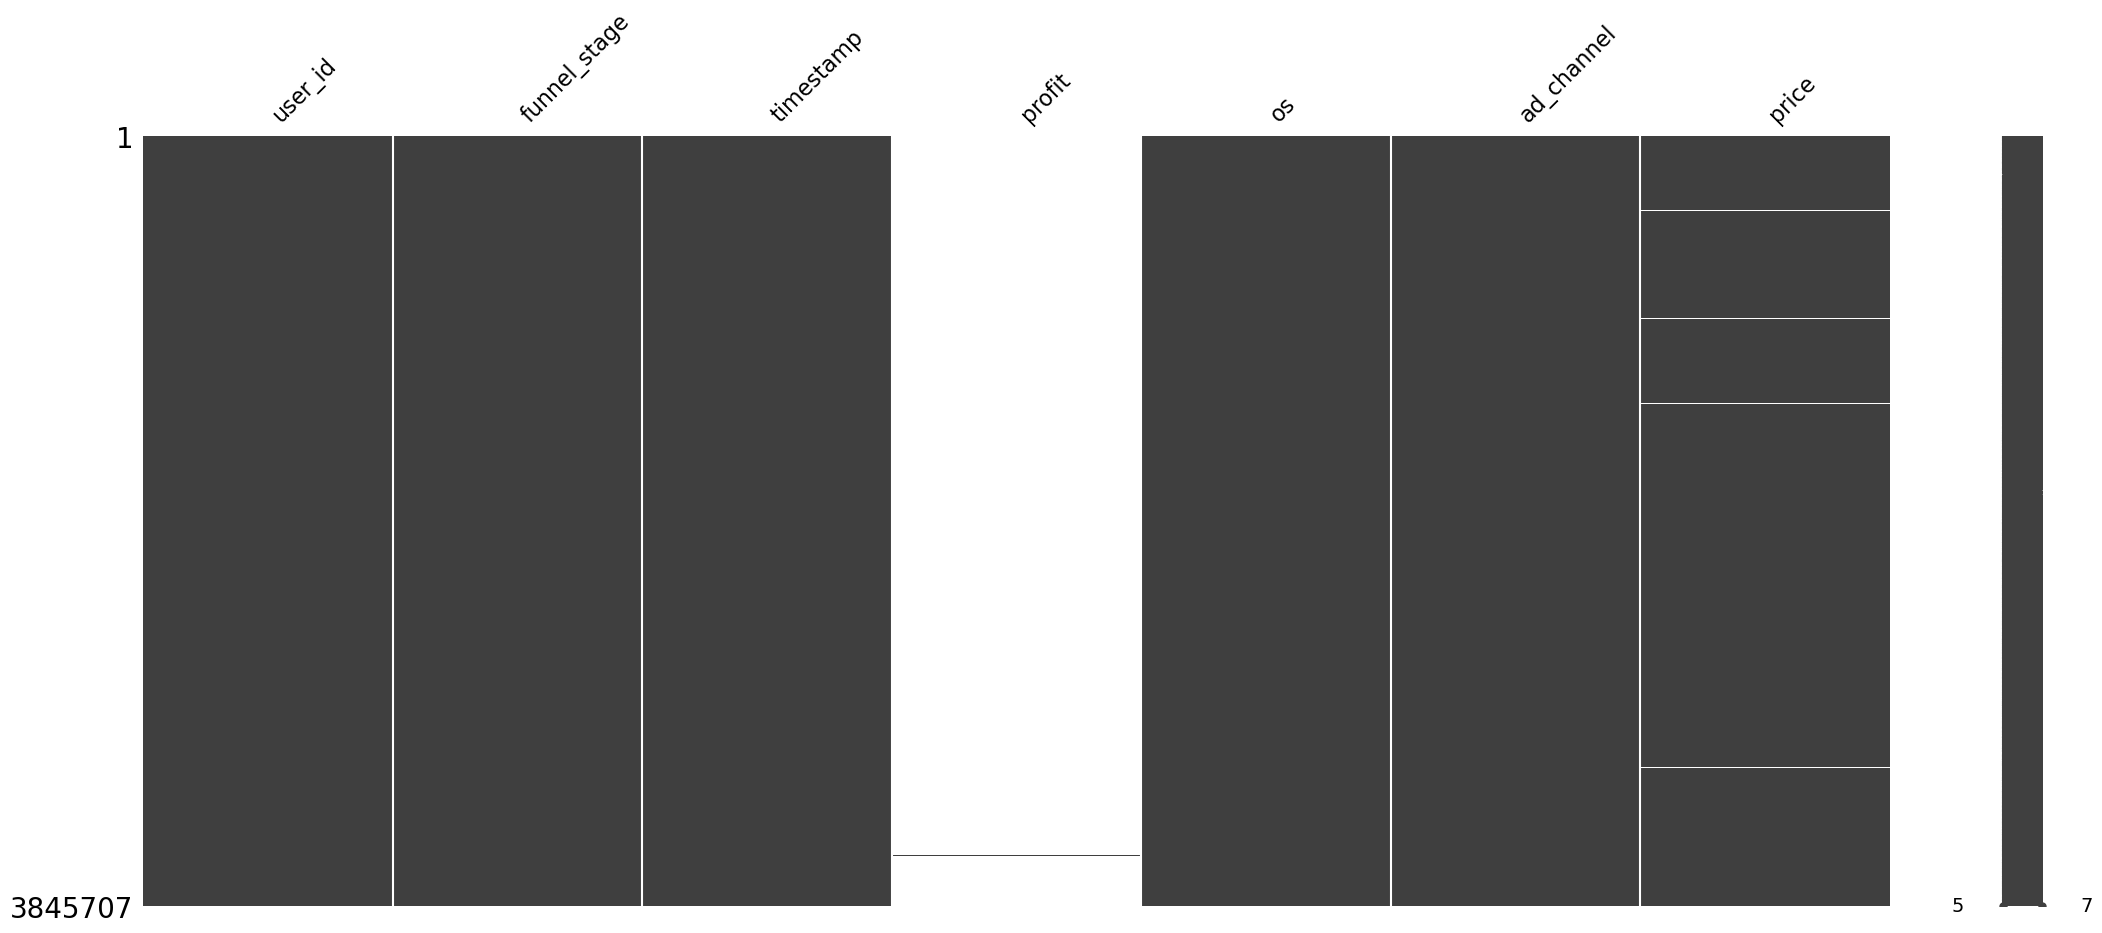

In [16]:
print('Матрица пропусков')
msno.matrix(df_new);

2. Вывод количества полностью заполненных объектов и их процент из всей выборки.

In [17]:
print(f'Количество полностью заполненных объектов для датасета: {len(df_new.dropna())}')
print(f'Процент полностью заполненных объектов в выборке датасета: {round((len(df_new.dropna()) / len(df_new)) * 100 , 2)} %')

Количество полностью заполненных объектов для датасета: 4834
Процент полностью заполненных объектов в выборке датасета: 0.13 %


3. Вывод процента пропущенных значений для каждого признака с сортировкой по убыванию процента

In [18]:
def missing_percent(data):
    missing_percent = round((data.isna().sum() / len(data) * 100), 2).sort_values(ascending = False)

    return missing_percent

In [19]:
missing_percent(df_new)

profit          99.87
price            0.59
user_id          0.00
funnel_stage     0.00
timestamp        0.00
os               0.00
ad_channel       0.00
dtype: float64

4. Сделаем копию датасета для последующией обработки.

In [20]:
df_clean = df_new.copy()

#### 3.1.1 Обработка пропусков в колонке `price`

1. Вывод количества значений для указанной колонки, включая пропущенные значения.

In [21]:
print('Для price:')
print(df_clean.price.value_counts(dropna = False))
print(f'Количество пропущенных значений в price: {df_clean.price.isna().sum()}')

Для price:
1.50    1491205
0.75     655068
0.50     576169
0.00     531584
1.00     387430
2.00     117575
2.50      64088
NaN       22588
Name: price, dtype: int64
Количество пропущенных значений в price: 22588


2. Обработка пропусков удалением записей

In [22]:
df_clean = df_clean[~(df_clean.price.isna())]

3. Контроль количества пропусков

In [23]:
print(f'Количество пропущенных значений в price: {df_clean.price.isna().sum()}')

Количество пропущенных значений в price: 0


#### 3.1.2 Обработка пропусков в колонке `profit`

1. Вывод количества значений для указанной колонки, включая пропущенные значения.

In [24]:
print('Для profit:')
print(df_clean.profit.value_counts(dropna = False))
print(f'Количество пропущенных значений в profit: {df_clean.profit.isna().sum()}')

Для profit:
NaN       3818285
1099.0        859
260.0         849
520.0         841
2136.0        826
130.0         733
50.0          726
Name: profit, dtype: int64
Количество пропущенных значений в profit: 3818285


2. Обработка пропусков путём замены на значение `0`

In [25]:
df_clean['profit'] = df_clean['profit'].fillna(0)

3. Контроль количества пропусков

In [26]:
print(f'Количество пропущенных значений в profit: {df_clean.profit.isna().sum()}')

Количество пропущенных значений в profit: 0


#### 3.1.3 Поиск аномалий в категориальных переменных

1. Вывод общей информации о датасете для анализа

In [27]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3823119 entries, 0 to 3190638
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   user_id       int64  
 1   funnel_stage  object 
 2   timestamp     int64  
 3   profit        float64
 4   os            object 
 5   ad_channel    object 
 6   price         float64
dtypes: float64(2), int64(2), object(3)
memory usage: 233.3+ MB


2. Для качественных переменных выведем уникальные значения и количесто их повторений

In [28]:
df_clean.funnel_stage.value_counts()

interest         1950345
INTEREST         1250609
consideration     199331
INTENT            162610
CONSIDERATION     138962
intent            116428
PURCHASE            3112
purchase            1722
Name: funnel_stage, dtype: int64

In [29]:
df_clean.os.value_counts()

Android    2018587
iOS        1804532
Name: os, dtype: int64

In [30]:
df_clean.ad_channel.value_counts()

search             1491205
video               655068
banner              576169
organic_traffic     531584
partner_network     387430
native              117575
rich                 64088
Name: ad_channel, dtype: int64

3. Обработаем атрибут `funnel_stage` путём замены заглавных букв на строчные

In [31]:
df_clean['funnel_stage'] = df_clean.funnel_stage.apply(lambda x: x.lower())

4. Контроль уникальных значений по атрибуту `funnel_stage`

In [32]:
df_clean.funnel_stage.value_counts()

interest         3200954
consideration     338293
intent            279038
purchase            4834
Name: funnel_stage, dtype: int64

5. Данные, поступившие от канала `other`, не требуются для работы. Строки данных с таким каналом привлечения были удалены в ходе обработки пропусков атрибута `price`, т.к. для данного канала отсутсвует стоимость привлечения.

#### 3.1.4 Поиск аномалий в количественных переменных

1. Для корректного отображения порядка воронки продаж присвоим значениям `funnel_stage` соответствующие номера.  Выведем количество уникальных пользователей, которое пришло по каждому рекламному каналу в разрезе этапов воронки.

In [33]:
sales_funnel = {
    'interest' : '1_interest',
    'consideration' : '2_consideration',
    'intent' : '3_intent',
    'purchase' : '4_purchase'
}

for i in sales_funnel.keys():
    df_clean.loc[df_clean['funnel_stage'] == i,'funnel_stage'] = sales_funnel[i]

In [34]:
df_clean.groupby(['ad_channel', 'funnel_stage']).nunique(['user_id'])

user_id  timestamp  profit  os  price
ad_channel      funnel_stage                                          
banner          1_interest         92003      43792       1   2      1
                2_consideration    47541      31587       1   2      1
                3_intent            7625       7182       1   2      1
                4_purchase           688        683       6   2      1
native          1_interest         19381      16273       1   2      1
                2_consideration    12597      11233       1   2      1
                3_intent             412        415       1   2      1
                4_purchase            37         37       4   2      1
organic_traffic 1_interest         78707      41702       1   2      1
                2_consideration    53592      34345       1   2      1
                3_intent            9163       8543       1   2      1
                4_purchase           542        541       6   2      1
partner_network 1_interest         66234      37625       1   2      1
                2_consideration    24721      19832       1   2      1
                3_intent            4420       4303       1   2      1
                4_purchase           450        448       4   2      1
rich            1_interest          8922       8308       1   2      1
                2_consideration     4657       4480       1   2      1
                3_intent            1238       1225       1   2      1
                4_purchase            22         22       2   2      1
search          1_interest        224668      54554       1   2      1
                2_consideration   134305      50908       1   2      1
                3_intent           27481      21928       1   2      1
                4_purchase          3090       2998       6   2      1
video           1_interest         97961      45118       1   2      1
                2_consideration    60880      36578       1   2      1
                3_intent              58         59       1   2      1
                4_purchase             5          5       3   2      1

In [35]:
#Для наглядности представим воронку в виде сводной таблицы
pd.pivot_table(df_clean, values = 'user_id', index = 'funnel_stage', columns = 'ad_channel', aggfunc = "nunique")

ad_channel,banner,native,organic_traffic,partner_network,rich,search,video
funnel_stage,,,,,,,
1_interest,92003,19381,78707,66234,8922,224668,97961
2_consideration,47541,12597,53592,24721,4657,134305,60880
3_intent,7625,412,9163,4420,1238,27481,58
4_purchase,688,37,542,450,22,3090,5


Применяя группировку получаем, что количество уникальных пользователей на каждом этапе воронки уменьшается, что соответствует логике воронки. Предполагается, что данные некоторых этапов воронки продаж могли быть сфальсифицированы «накликиванием». Проанализируем, сколько действий в один момент времени совершает пользователь.

In [36]:
df_clean.sort_values(by = 'timestamp', ascending = True).head(20)

,user_id,funnel_stage,timestamp,profit,os,ad_channel,price
0,219687,1_interest,150000,0.0,Android,banner,0.50
3,795063,1_interest,150000,0.0,Android,banner,0.50
2,108759,1_interest,150000,0.0,Android,banner,0.50
1,335514,1_interest,150000,0.0,Android,banner,0.50
4,928373,1_interest,150000,0.0,iOS,banner,0.50
640257,991236,1_interest,150000,0.0,Android,native,2.00
3190640,793204,2_consideration,150000,0.0,Android,video,0.75
1699437,399556,1_interest,150000,0.0,iOS,search,1.50
3190639,111649,2_consideration,150000,0.0,Android,video,0.75
1699435,619571,2_consideration,150000,0.0,iOS,search,1.50


2. Визуализируем полученные данные

<AxesSubplot:xlabel='timestamp', ylabel='Count'>

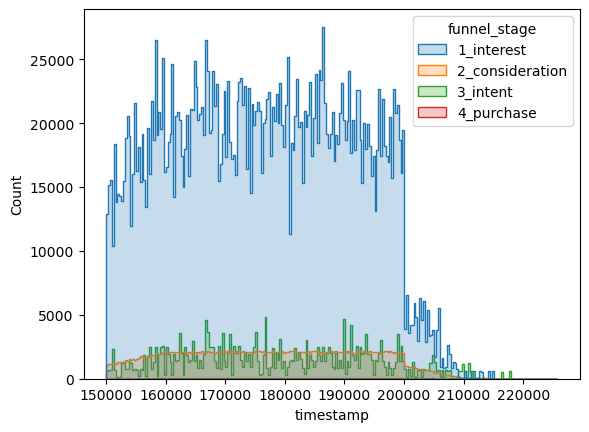

In [37]:
sns.histplot(df_clean, x="timestamp", hue="funnel_stage", element="step")

<AxesSubplot:xlabel='user_id', ylabel='Count'>

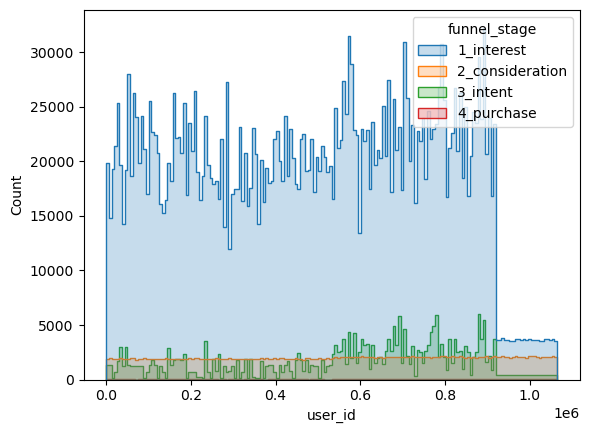

In [38]:
sns.histplot(df_clean, x="user_id", hue="funnel_stage", element="step")

3. Определим число действий, совершаемых пользователями в один момент времени.

In [39]:
time_count = df_clean.groupby(['user_id','funnel_stage', 'ad_channel'], as_index = False).agg({'timestamp' : 'count'}).rename(columns={"timestamp": "timestamp_count"}).sort_values(by = 'timestamp_count', ascending = False)
time_count

,user_id,funnel_stage,ad_channel,timestamp_count
473938,548488,1_interest,search,600
698459,777180,1_interest,banner,600
338828,393799,1_interest,organic_traffic,600
750330,829571,1_interest,search,600
107637,124384,1_interest,video,600
...,...,...,...,...
328106,381182,1_interest,banner,1
328107,381182,1_interest,search,1
328108,381182,2_consideration,search,1
328109,381183,1_interest,organic_traffic,1


4. Выделим ботов по принципу, что пользователь не может совершать более 1 действия одновременно. Визуализируем полученные группы.

In [40]:
fraud = time_count[time_count['timestamp_count'] != 1]

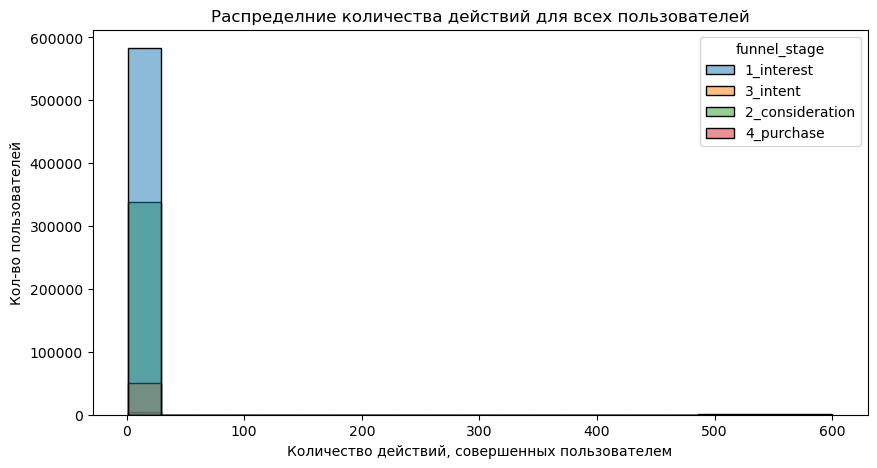

In [41]:
plt.figure(figsize = (10,5))

sns.histplot(time_count, x="timestamp_count", hue="funnel_stage", element="bars")
plt.xlabel('Количество действий, совершенных пользователем')
plt.ylabel('Кол-во пользователей')
plt.title('Распределние количества действий для всех пользователей')
plt.show()

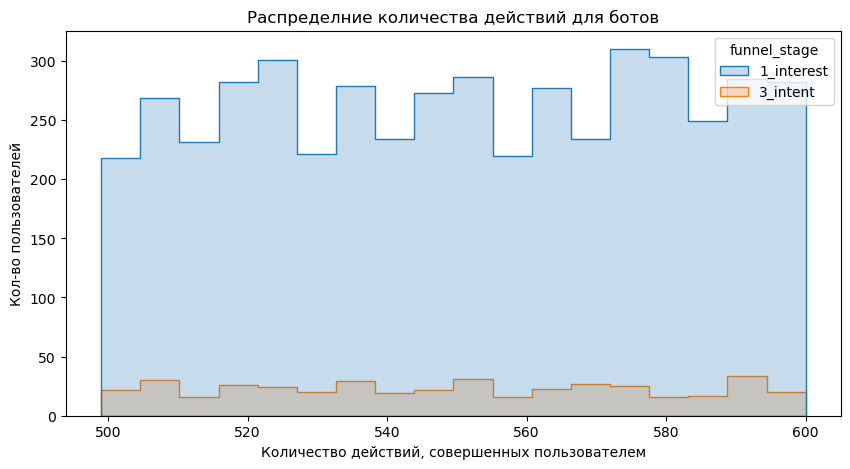

In [42]:
plt.figure(figsize = (10,5))

sns.histplot(fraud, x="timestamp_count", hue="funnel_stage", element="step")
plt.xlabel('Количество действий, совершенных пользователем')
plt.ylabel('Кол-во пользователей')
plt.title('Распределние количества действий для ботов')
plt.show()

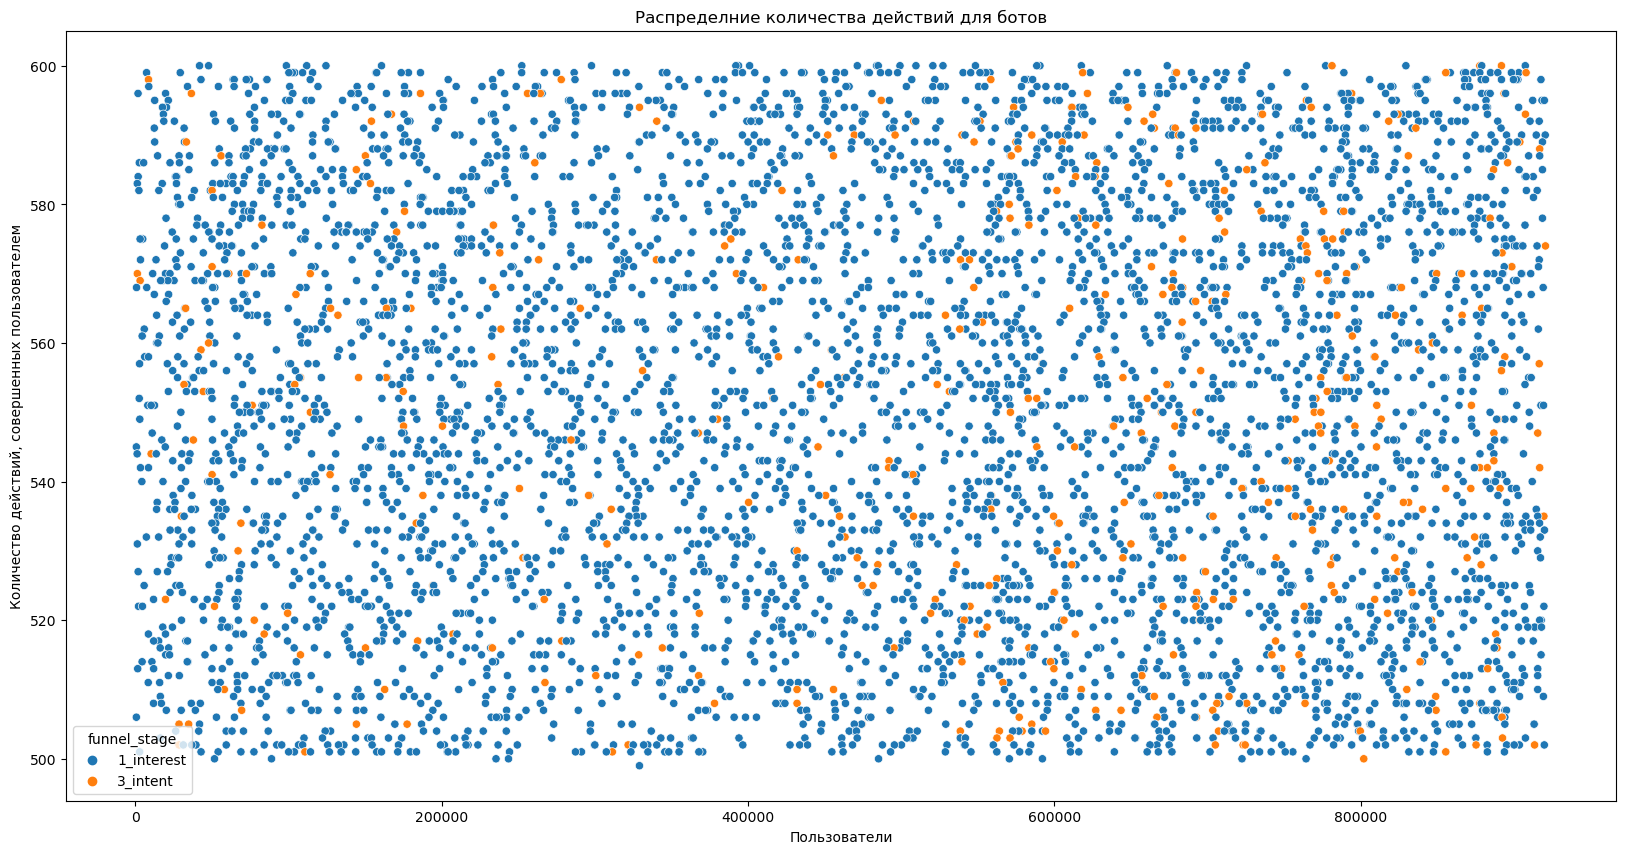

In [43]:
plt.figure(figsize = (20,10))

sns.scatterplot(data=fraud, x="user_id", y="timestamp_count", hue="funnel_stage")
plt.ylabel('Количество действий, совершенных пользователем')
plt.xlabel('Пользователи')
plt.title('Распределние количества действий для ботов')
plt.show()

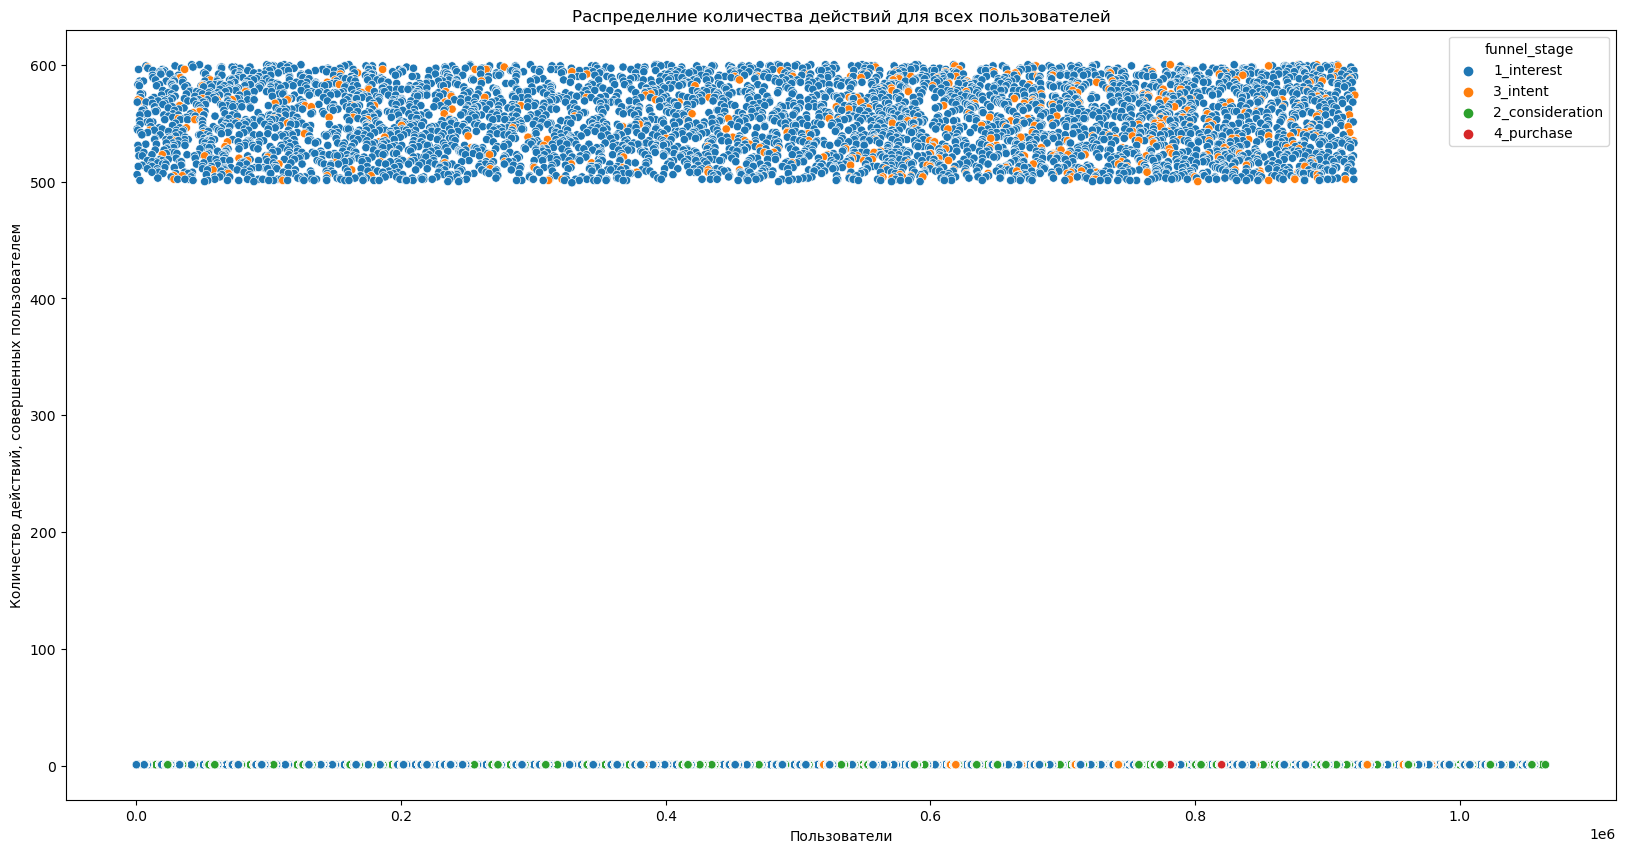

In [44]:
plt.figure(figsize = (20,10))

sns.scatterplot(data=time_count, x="user_id", y="timestamp_count", hue="funnel_stage")
plt.ylabel('Количество действий, совершенных пользователем')
plt.xlabel('Пользователи')
plt.title('Распределние количества действий для всех пользователей')
plt.show()

Как видно из графиков, наибольшее количество ботов приходится на этап `1_interest`, а также на этап `3_intent`

5. Выведем процент фродовых пользователей от общего числа и сохраним фродовые данные в отдельную таблицу, а итоговый датасет очистим от этих данных

In [45]:
df_final = pd.merge(left = df_clean, right = time_count, on = ['user_id', 'funnel_stage', 'ad_channel'], how = 'inner')
fraud_data = df_final[df_final['timestamp_count'] != 1]
df_final = df_final[~(df_final['timestamp_count'] != 1)]

In [46]:
print(f'Процент ботов от общего числа пользователей: {round((fraud_data.user_id.nunique() / df_clean.user_id.nunique()) * 100, 2)} %')

Процент ботов от общего числа пользователей: 0.82 %


## 4. Feature Engineering

### 4.1 Преобразование категориальных переменных

1. Перекодируем категориальные переменные, относящиеся к операционной системе и этапам воронки, в бинарный и нумерованный вид в зависимости от этапа соответственно.

Для операционной системы определим атрибут `os_Android`, для которого значение `1` будет соответствовать ОС Android, а для `0` - ОС iOS.

Для этапов воронки определим атрибут `funnel_stage_num`, который будет соответствовать порядковому номеру этапа воронки.

In [47]:
df_final['os_Android'] = df_final.apply(lambda x: 1 if x.os == 'Android' else 0, axis = 1)

df_final['funnel_stage_num'] = df_final.apply(lambda x: int(x.funnel_stage.split('_')[0]), axis = 1)

2. Методом `LabelEncoder` закодируем значения атрибута `ad_channel` и добавим в датасет

In [48]:
le = LabelEncoder()
le.fit(df_final['ad_channel'])
le_ad_channel = le.transform(df_final['ad_channel'])
df_final['le_ad_channel'] = le_ad_channel

3. Выполним корреляционный анализ стандартным способом, а также выведем матрицу корреляции

In [49]:
df_corr = df_final[['user_id', 'timestamp', 'profit', 'price', 'os_Android', 'funnel_stage_num','le_ad_channel']]
df_corr = df_corr.apply(lambda x: pd.factorize(x)[0])

In [50]:
#Корреляционная матрица
df_corr.corr(method = 'pearson')

,user_id,timestamp,profit,price,os_Android,funnel_stage_num,le_ad_channel
user_id,1.000000,0.860599,-0.011395,-0.059193,-0.009566,-0.014365,-0.059193
timestamp,0.860599,1.000000,0.017923,-0.012594,0.002070,0.054359,-0.012594
profit,-0.011395,0.017923,1.000000,-0.013170,0.008031,0.260000,-0.013170
price,-0.059193,-0.012594,-0.013170,1.000000,0.105776,-0.048535,1.000000
os_Android,-0.009566,0.002070,0.008031,0.105776,1.000000,0.013057,0.105776
funnel_stage_num,-0.014365,0.054359,0.260000,-0.048535,0.013057,1.000000,-0.048535
le_ad_channel,-0.059193,-0.012594,-0.013170,1.000000,0.105776,-0.048535,1.000000


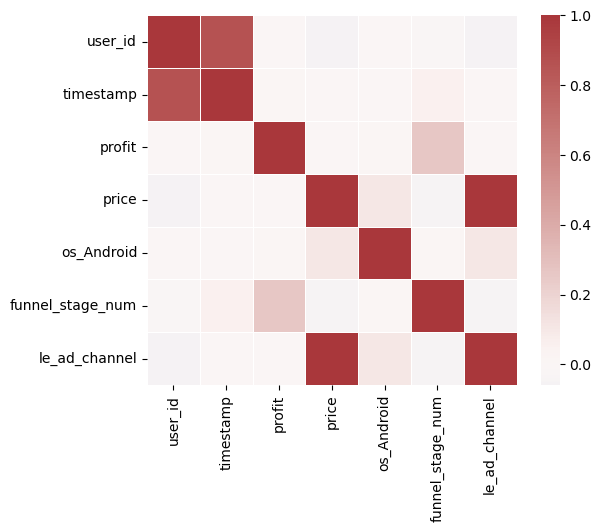

In [51]:
sns.heatmap(df_corr.corr(method = 'pearson'), cmap = 'vlag' , center = 0 , square = True, linewidths = 0.5)
plt.show()

5. Определим корреляцию для цены и идентификатора пользователя с помощью коэффициента Пирсона

In [52]:
alpha = 0.95
result = st.pearsonr(df_corr.price,df_corr.user_id)
result

PearsonRResult(statistic=-0.059193358534627885, pvalue=0.0)

In [53]:
result.confidence_interval(confidence_level = alpha)

ConfidenceInterval(low=-0.06116985921229929, high=-0.05721639363756323)

**Вывод:** Исходя из полученных результатов, гипотеза о том, что коэффициент корреляции Пирсона равен 0, подтверждена. Нельзя судить о том, что идентификатор пользователя влияет на цену.

5. Выполним факторный анализ

In [54]:
df_factr = df_final[['user_id', 'timestamp', 'profit', 'price', 'os_Android', 'funnel_stage_num','le_ad_channel']]
df_factr = df_factr.apply(lambda x: pd.factorize(x)[0])

Стандартизируем переменные и проведём тест Бартлетта для подтверждения гипотезы о том, что корреляционная матрица является единичной диагональной

In [55]:
sc=StandardScaler()
x_stand = sc.fit_transform(df_factr)
statistic, p_value = calculate_bartlett_sphericity(x_stand)
p_value

0.0

Гипотеза о том, что корреляционная матрица является единичной диагональной, подтверждена

In [56]:
fa = FactorAnalyzer(n_factors = 2)
fa.fit(x_stand)
ev, v = fa.get_eigenvalues()

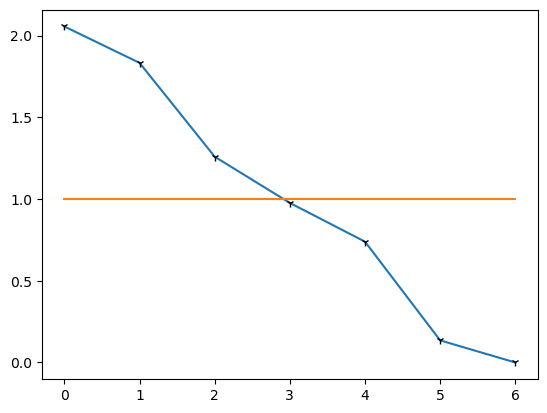

In [57]:
sns.lineplot(data = ev, marker = '1', markeredgewidth = 1, markeredgecolor = 'black')
plt.plot((0,6), (1,1))
plt.show()

Из графика можно увидеть, что 3 фактора имеют собственное значение больше 1. Проведём вращение осей и выведем итоговую матрицу

In [58]:
fa = FactorAnalyzer(n_factors = 3)
fa.fit(x_stand)
loadings = fa.loadings_
df_fa = pd.DataFrame(loadings, index = df_factr.columns)
df_fa.columns = ['factor_{x}'.format(x = x+1) for x in range(3)]                  

In [59]:
df_fa.sort_values(by = 'factor_1', ascending= False)

,factor_1,factor_2,factor_3
le_ad_channel,0.998078,0.001047,-0.075831
price,0.998078,0.001047,-0.075831
os_Android,0.107056,-0.000208,0.016552
timestamp,0.026675,0.943802,0.044577
profit,0.002719,-0.002727,0.337428
funnel_stage_num,-0.011957,0.006591,0.770795
user_id,-0.025643,0.914658,-0.042813


In [60]:
df_fa.sort_values(by = 'factor_2', ascending= False)

,factor_1,factor_2,factor_3
timestamp,0.026675,0.943802,0.044577
user_id,-0.025643,0.914658,-0.042813
funnel_stage_num,-0.011957,0.006591,0.770795
price,0.998078,0.001047,-0.075831
le_ad_channel,0.998078,0.001047,-0.075831
os_Android,0.107056,-0.000208,0.016552
profit,0.002719,-0.002727,0.337428


In [61]:
df_fa.sort_values(by = 'factor_3', ascending= False)

,factor_1,factor_2,factor_3
funnel_stage_num,-0.011957,0.006591,0.770795
profit,0.002719,-0.002727,0.337428
timestamp,0.026675,0.943802,0.044577
os_Android,0.107056,-0.000208,0.016552
user_id,-0.025643,0.914658,-0.042813
le_ad_channel,0.998078,0.001047,-0.075831
price,0.998078,0.001047,-0.075831


In [62]:
x_transf = pd.DataFrame(fa.transform(x_stand))
x_transf

,0,1,2
0,-1.498438,-1.740735,-0.562006
1,-0.816764,-1.746543,-0.573748
2,-0.816764,-1.746540,-0.573748
3,-0.816764,-1.746538,-0.573749
4,-0.728188,-1.756996,0.597653
...,...,...,...
976224,0.047530,2.058762,1.867096
976225,0.047708,2.052755,1.869083
976226,-0.723668,2.037839,0.701345
976227,-0.340207,2.024967,5.751258


**Вывод:** На основании полученных результатов было выявлено 3 фактора, которые объединяют следующие признаки:

Фактор 1 - (`le_ad_channel` и `user_id`);
Фактор 2 - (`timestamp` и `profit`);
Фактор 3 - (`funnel_stage_num` и `price`).

Следует обратить внимание на Факторы 2 и 3, т.к. они влияют на показатель прибыли на этапе покупки и затрат на рекламу

## 5. Data Visualization

### 5.1 Распределение количества этапов воронки, которые были скомпрометированы

1. Подготовка данных

In [63]:
fraud_funnel_stage = fraud_data.groupby('funnel_stage', as_index = False).agg(act_count = ('user_id','count'))
fraud_funnel_stage

,funnel_stage,act_count
0,1_interest,2617832
1,3_intent,229058


2. Визуализируем полученные данные

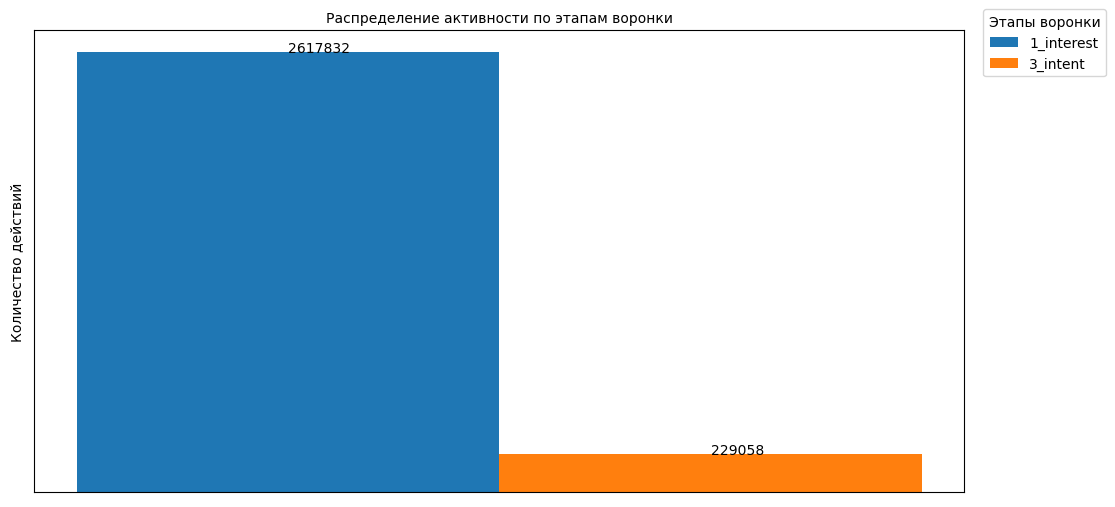

In [64]:
fig, ax = plt.subplots(figsize = (12,6))

bar_width = 0.2
index = len(fraud_funnel_stage['funnel_stage'])

ax.bar(index, fraud_funnel_stage['act_count'][0], bar_width, label = '1_interest')
ax.bar(index + bar_width, fraud_funnel_stage['act_count'][1], bar_width, label = '3_intent')
ax.xaxis.set_major_locator(ticker.NullLocator())
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.yaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_formatter(ticker.NullFormatter())
ax.text(index, fraud_funnel_stage['act_count'][0], str(fraud_funnel_stage['act_count'][0]))
ax.text(index + bar_width, fraud_funnel_stage['act_count'][1], str(fraud_funnel_stage['act_count'][1]))

ax.set_title('Распределение активности по этапам воронки',fontsize = 10)
ax.set_ylabel('Количество действий',fontsize = 10)
ax.legend(title = 'Этапы воронки', loc= (1.02, 0.90))
plt.show()

3. Почему именно эти этапы оказались легко атакованы?

Исходя из описания воронки, этапы `interest` и `intent` включают в себя совершение конкретного дейтсвия, например: клик по рекламному баннеру, переход на сайт, выбор плана, заявка на обратную связь или регистрация. Данные конкретные дейсвия легко программируются в бот и быстро им совершаются по сравнению с этапом `consideration`, где требуется время для хождения по продуктовым страницам. Наибольшее количество сфальсифицированных действий приходится на этап `interest`, что характеризуется наиболее простыми шагами для попадания в выборку данного этапа. 

### 5.2 Воронка продаж по всем каналам коммуникации с клиентом

1. Подготовка данных

In [65]:
channel_funnel_stage = df_final.groupby(['ad_channel','funnel_stage'], as_index = False).agg(act_count = ('user_id','count'))
channel_funnel_stage

,ad_channel,funnel_stage,act_count
0,banner,1_interest,91283
1,banner,2_consideration,47541
2,banner,3_intent,7566
3,banner,4_purchase,688
4,native,1_interest,19229
5,native,2_consideration,12597
6,native,3_intent,409
7,native,4_purchase,37
8,organic_traffic,1_interest,78065
9,organic_traffic,2_consideration,53592


2. Визуализируем полученные данные

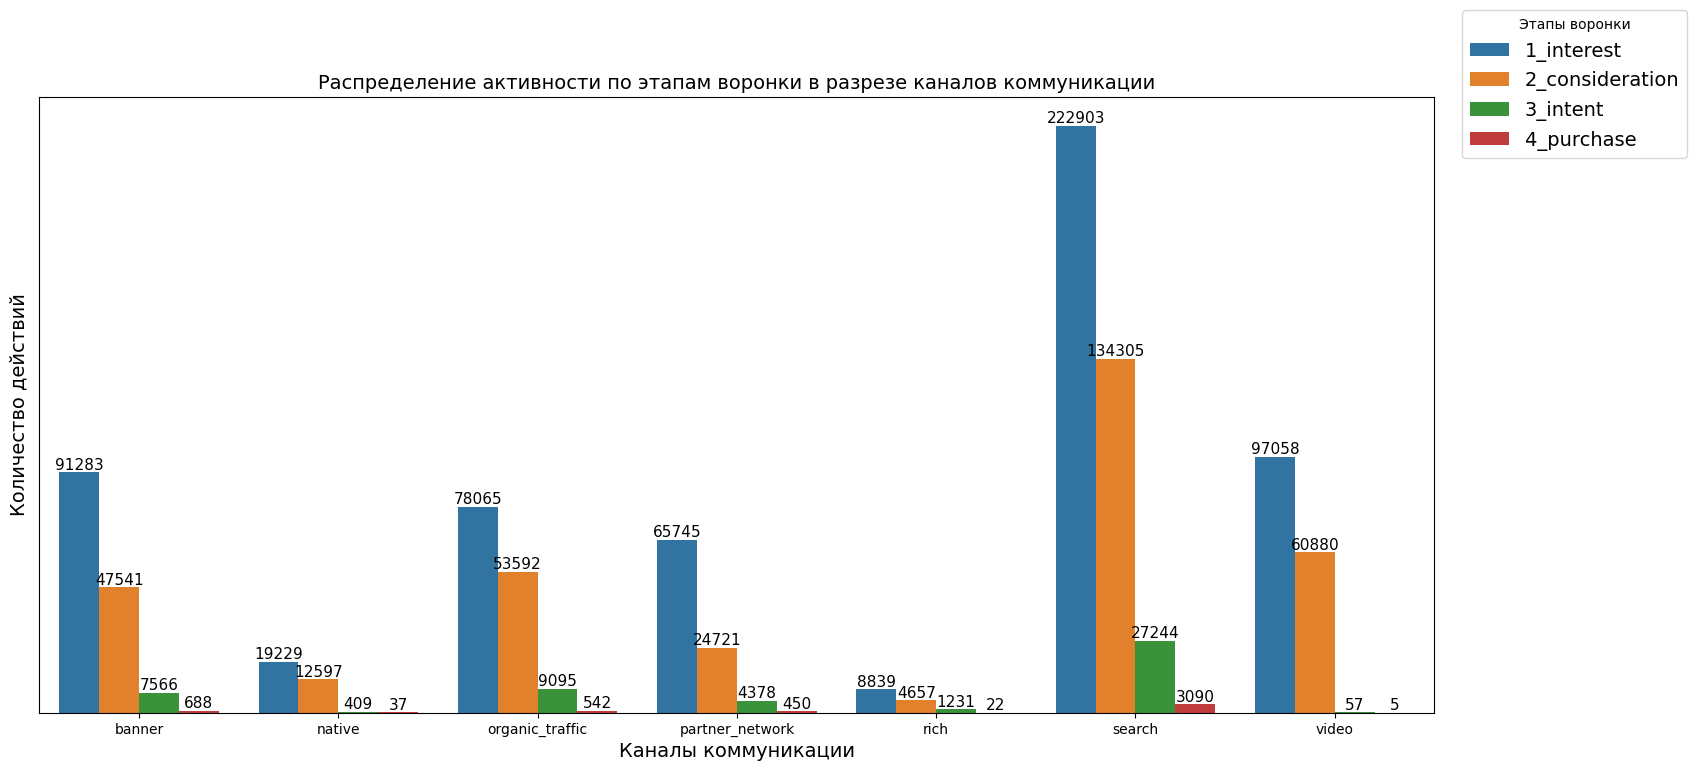

In [66]:
fig, ax = plt.subplots(figsize = (18,8))

bar = sns.barplot(x = 'ad_channel', y = 'act_count', data = channel_funnel_stage, hue = 'funnel_stage')
for bars in ax.containers:
        bar.bar_label(bars,fontsize = 11)
ax.yaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_formatter(ticker.NullFormatter())

ax.set_title('Распределение активности по этапам воронки в разрезе каналов коммуникации',fontsize = 14)
ax.set_xlabel('Каналы коммуникации', fontsize = 14)
ax.set_ylabel('Количество действий', fontsize = 14)
ax.legend(title = 'Этапы воронки',fontsize = 14, loc= (1.02, 0.90))
plt.show()


3. Какой канал коммуникации кажется менее перспективным?

Наименее перспективным является канал `video`, т.к. при 97058 действиях на этапе `interest` только 5 действий приходится на этап `purchase`, что соответствует конверсии в 0,005% из интереса в покупку.

### 5.3 Затраты для каждого рекламного канала и прибыль по ним на последнем этапе воронки. 

1. Подготовка данных

In [67]:
price_and_profit = df_final.groupby(['ad_channel'], as_index = False).agg(profit_total = ('profit','sum'), price_total = ('price','sum')).sort_values(['profit_total'], ascending=False)
price_and_profit

,ad_channel,profit_total,price_total
5,search,2112193.0,581313.0
0,banner,497881.0,73539.0
3,partner_network,445411.0,95294.0
2,organic_traffic,367094.0,0.0
1,native,37355.0,64544.0
4,rich,33511.0,36872.5
6,video,4582.0,118500.0


2. Визуализируем полученные данные

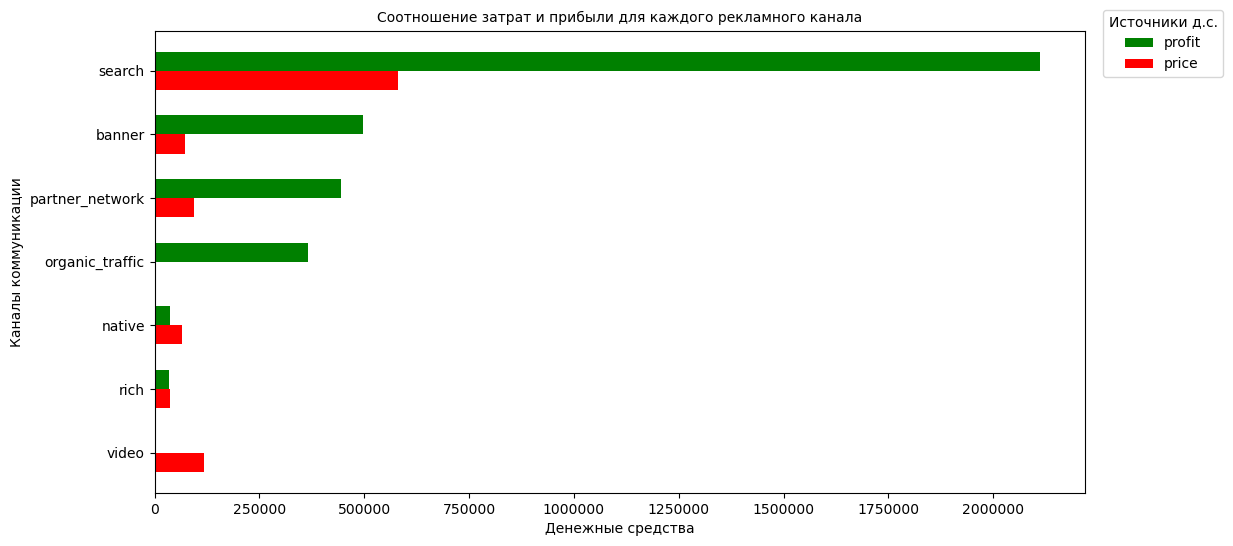

In [68]:
fig, ax = plt.subplots(figsize = (12,6))

bar_width = 0.3
y_pos = np.arange(len(price_and_profit))


ax.barh(y_pos, price_and_profit.profit_total, bar_width, color = 'g', label = 'profit')
ax.barh(y_pos + bar_width, price_and_profit.price_total, bar_width, color = 'r', label = 'price')
ax.set_yticks(y_pos + bar_width / 2, labels = price_and_profit.ad_channel)
ax.invert_yaxis()

ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

ax.set_title('Соотношение затрат и прибыли для каждого рекламного канала',fontsize = 10)
ax.set_ylabel('Каналы коммуникации',fontsize = 10)
ax.set_xlabel('Денежные средства',fontsize = 10)
ax.legend(title = 'Источники д.с.', loc= (1.02, 0.90))
plt.show()

3. Вывод

Как видно на графике, несмотря на вложенные средства, канал `video` не принёс прибыли. Следует перераспределить затраты данного канала на более результативные направления.

### 5.4 Распределение операционной системы пользователя для каждого канала коммуникации. 

1. Подготовка данных

In [69]:
OS_per_channel = df_final.groupby(['ad_channel', 'os'], as_index = False).agg(os_count = ('os','count'))
OS_per_channel

,ad_channel,os,os_count
0,banner,Android,103002
1,banner,iOS,44076
2,native,Android,9837
3,native,iOS,22435
4,organic_traffic,Android,84913
5,organic_traffic,iOS,56381
6,partner_network,Android,47632
7,partner_network,iOS,47662
8,rich,Android,2987
9,rich,iOS,11762


2. Визуализируем полученные данные

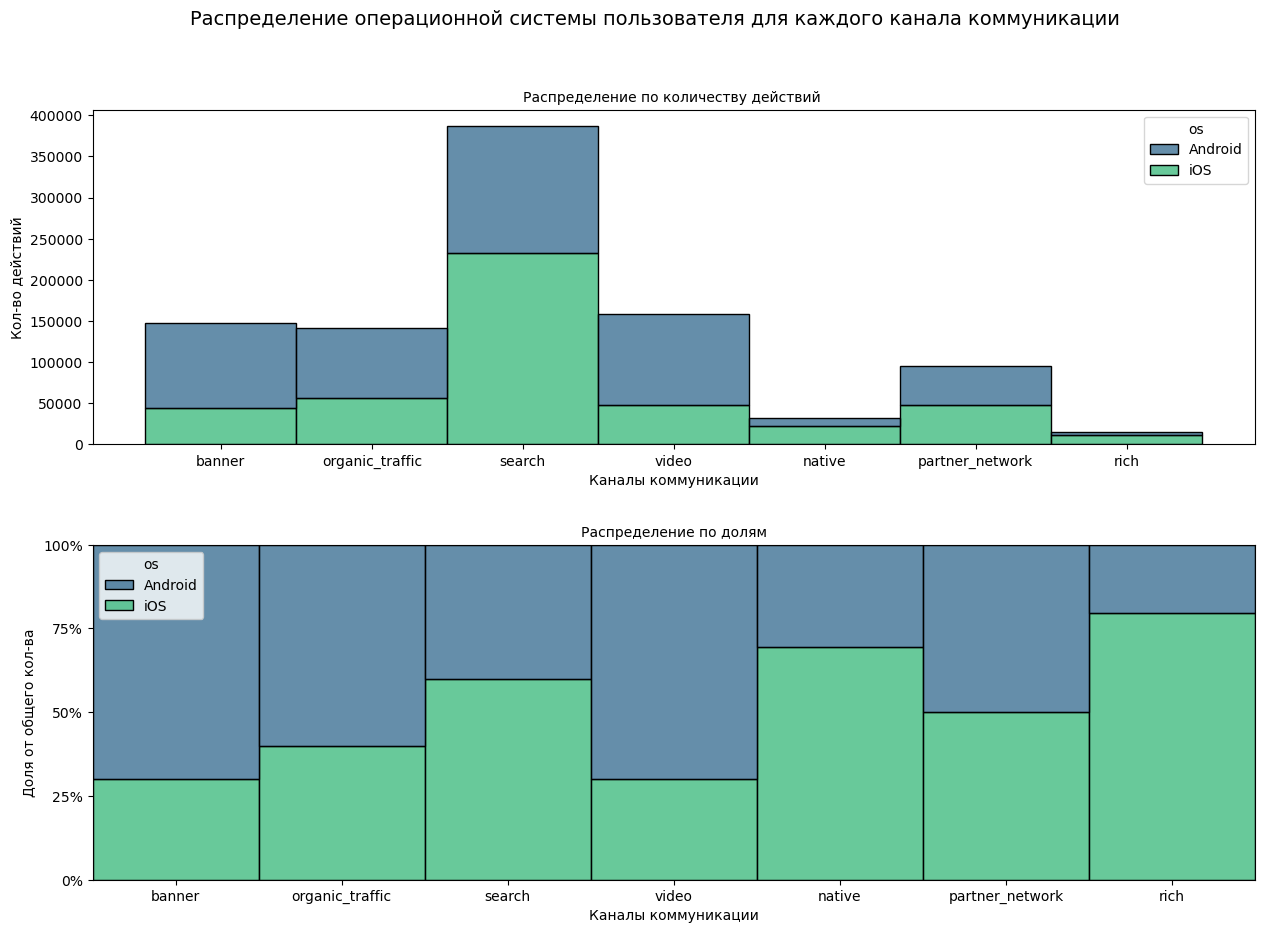

In [70]:
fig, ax = plt.subplots(2, 1, figsize = (15,10))
fig.suptitle('Распределение операционной системы пользователя для каждого канала коммуникации', fontsize= 14)
fig.subplots_adjust(hspace = 0.3)


sns.histplot(data = df_final, x = 'ad_channel', hue = 'os', multiple="stack", palette = 'viridis', ax = ax[0])
ax[0].set_title('Распределение по количеству действий ', fontsize = 10)
ax[0].set_xlabel('Каналы коммуникации', fontsize = 10)
ax[0].set_ylabel('Кол-во действий', fontsize = 10)

sns.histplot(data = df_final, x = 'ad_channel', hue = 'os', multiple="fill", palette = 'viridis', ax = ax[1])
ax[1].yaxis.set_major_locator(ticker.MaxNLocator(4))
ax[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax = 1))
ax[1].set_title('Распределение по долям', fontsize = 10)
ax[1].set_xlabel('Каналы коммуникации', fontsize = 10)
ax[1].set_ylabel('Доля от общего кол-ва', fontsize = 10)

plt.show()

3. Вывод

Как видно на графиках, на операционную систему iOS приходится большая часть активности. Наибольшая активность по количеству действий приходится на канал `search`, а по каналу `rich` отмечается наибольшая доля операционной системы iOS из всех совершенных действий.

## 6. Modeling

### 6.1 Насколько статистически значимы отличия между долями пользователей на каждом этапе воронки между платным и органическим трафиком?

1. Подготовка данных для формулирования и проверки гипотезы. Разделим данные на две группы: органический трафик (прямые ссылки на сайт и поисковые переходы, за которые рекламодатель не платит) и рекламный трафик (всё остальное).

In [71]:
organic_traffic = df_final[df_final['ad_channel'] == 'organic_traffic']
paid_traffic = df_final[df_final['ad_channel'] != 'organic_traffic']

In [72]:
organic_data = organic_traffic.groupby('funnel_stage', as_index = False).agg(user_count = ('user_id','count'))
organic_data

,funnel_stage,user_count
0,1_interest,78065
1,2_consideration,53592
2,3_intent,9095
3,4_purchase,542


In [73]:
paid_data = paid_traffic.groupby('funnel_stage', as_index = False).agg(user_count = ('user_id','count'))
paid_data

,funnel_stage,user_count
0,1_interest,505057
1,2_consideration,284701
2,3_intent,40885
3,4_purchase,4292


2. Сформулируем нулевую и альтернативную гипотезы.

Нулевая гипотеза: Органический трафик не отличается от платного по количеству пользователей на этапах воронки

Альтернативная гипотеза: Органический трафик отличается от платного по количеству пользователей на этапах воронки

3. Сформируем выборку для проверки гипотезы. 

In [74]:
data_for_modeling = pd.merge(left = organic_data, 
                             right = paid_data, 
                             on = 'funnel_stage', 
                             how = 'inner'
                            )
data_for_modeling

,funnel_stage,user_count_x,user_count_y
0,1_interest,78065,505057
1,2_consideration,53592,284701
2,3_intent,9095,40885
3,4_purchase,542,4292


4. Определим статистические критерии и подберём корректный тест для проверки гипотезы. 

Принимая во внимание, что сформированные выборки независимы друг от друга, определим, распределены ли выборки нормально. Для этого используем тест Шапиро - Уилка, где установим нулевую гипотезу о нормальности распределений с уровнем значимости p-value 5%.

In [76]:
print(st.shapiro(data_for_modeling.user_count_x))
print(st.shapiro(data_for_modeling.user_count_y))

ShapiroResult(statistic=0.9073085784912109, pvalue=0.46825921535491943)
ShapiroResult(statistic=0.9049592614173889, pvalue=0.4561072587966919)


По результатам теста Шапиро - Уилка для обоих выборок значение p-value составило >5%, из чего следует, что нулевая гипотеза о нормальности распределений подтверждена. 

Учитывая, что выборки независимы и нормальность распределений подтверждена, определим, имеют ли выборки одинаковую дисперсию. Для этого проведём тест Левена, где установим нулевую гипотезу о равенстве дисперсий с уровнем значимости p-value 5%.

In [77]:
st.levene(data_for_modeling.user_count_x, data_for_modeling.user_count_y)

LeveneResult(statistic=8.602864214988402, pvalue=0.026182568591592598)

По результатам теста Левена значение p-value составило <5%, из чего следует, что нулевая гипотеза о равенстве дисперсий не подтверждена. 

5. Исходя из того,что выборки независимы, нормальность распределений подтверждена, а дисперсии не равны, то для проверки основной нулевой гипотезы  применяется t-критерий Уэлча с уровнем значимости 5%. Альтернативной гипотезой определим, что среднее значение первой выборки больше среднего значения второй выборки.

In [82]:
st.ttest_ind(data_for_modeling.user_count_x, data_for_modeling.user_count_y, equal_var=False, alternative = 'greater')

Ttest_indResult(statistic=-1.4673040237765962, pvalue=0.8827816427281558)

6. **Вывод:** По итогам проведённых тестов нулевая гипотеза о том, что органический трафик не отличается от платного по количеству пользователей на этапах воронки, подтверждена.

### 6.2 Определим лучший и худший каналы по данным на этапах consideration, intent, purchase.

1. Подготовка данных

In [83]:
data_for_modeling_2 = df_final.groupby(['ad_channel', 'funnel_stage'], as_index = False).agg(user_count = ('user_id','count'))

counts = data_for_modeling_2.user_count.tolist()
CR = []

for i in range(len(data_for_modeling_2)):
    if i == 0:
        CR.append(0)
    else:
        CR.append(round((counts[i] / counts[i-1]) * 100, 2))
    
data_for_modeling_2['CR'] = CR

data_for_modeling_2 = data_for_modeling_2[data_for_modeling_2['funnel_stage'] != '1_interest']

In [84]:
pd.pivot_table(data_for_modeling_2, values='CR', index='funnel_stage', columns='ad_channel')

ad_channel,banner,native,organic_traffic,partner_network,rich,search,video
funnel_stage,,,,,,,
2_consideration,52.08,65.51,68.65,37.60,52.69,60.25,62.73
3_intent,15.91,3.25,16.97,17.71,26.43,20.29,0.09
4_purchase,9.09,9.05,5.96,10.28,1.79,11.34,8.77


2. Визуализируем полученные данные

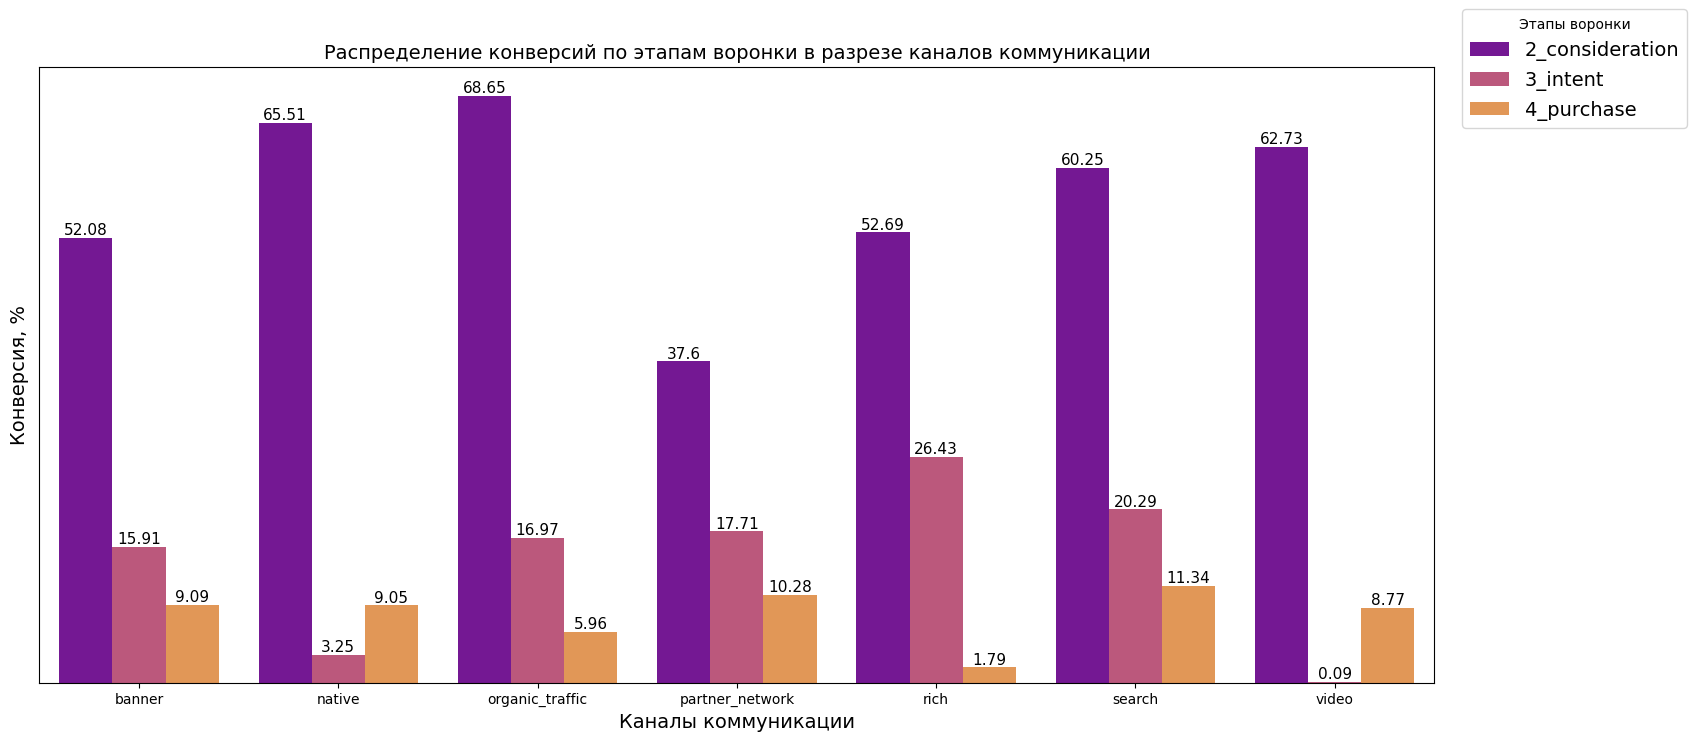

In [85]:
fig, ax = plt.subplots(figsize = (18,8))

bar = sns.barplot(x = 'ad_channel', 
                  y = 'CR', 
                  data = data_for_modeling_2, 
                  hue = 'funnel_stage', 
                  palette = 'plasma'
                 )
for bars in ax.containers:
        bar.bar_label(bars,fontsize = 11)
ax.yaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_formatter(ticker.NullFormatter())

ax.set_title('Распределение конверсий по этапам воронки в разрезе каналов коммуникации',fontsize = 14)
ax.set_xlabel('Каналы коммуникации', fontsize = 14)
ax.set_ylabel('Конверсия, %', fontsize = 14)
ax.legend(title = 'Этапы воронки',fontsize = 14, loc= (1.02, 0.90))
plt.show()


3. **Вывод**

Исходя из полученных данных по конверсиям и их визуальзации можно определить, что:
- для этапа воронки `2_consideration` лучшим и худшим каналами являются `organic_traffic` и `partner_network` соответсвенно;
- для этапа воронки `3_intent` лучшим и худшим каналами являются `rich` и `video` соответсвенно;
- для этапа воронки `4_purchase` лучшим и худшим каналами являются `search` и `rich` соответсвенно.

### 6.3 Какой канал следует отключить и перераспределить показы, чтобы увеличить продажи?

1. Для всех каналов коммуникации выведем маркетинговую метрику ROMI.

In [86]:
ROMI_ROI_data = price_and_profit
ROMI_ROI_data['ROMI'] = round(ROMI_ROI_data['profit_total'] / ROMI_ROI_data['price_total'] * 100 , 2)
ROMI_ROI_data[ROMI_ROI_data['ad_channel'] != 'organic_traffic']

,ad_channel,profit_total,price_total,ROMI
5,search,2112193.0,581313.0,363.35
0,banner,497881.0,73539.0,677.03
3,partner_network,445411.0,95294.0,467.41
1,native,37355.0,64544.0,57.88
4,rich,33511.0,36872.5,90.88
6,video,4582.0,118500.0,3.87


2. **Вывод**

Основываясь на полученных данных, а также на проведённых ранее расчётах, видится целесообразным признать канал `video` наименее эффективным с точки зрения конверсии из интереса в покупку, а также возврата вложенных инвестиций (1 вложенная денежная единица приносит 0,0387 единиц прибыли).

В целях увеличения продаж высвободившиеся средства следует перераспределить на канал `banner` как наиболее результативного по возврату вложенных средств, а также имеющего показатели конверсий выше среднего между этапами воронки.